In [1]:
import cdm
import numpy as np
import torch

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = cdm.VariationalDiffusion(32,32, n_blocks=4).to(device)

In [3]:
def loss(model: cdm.VariationalDiffusion, img, conditioning=None, beta=1.):
    l1, l2, l3 = model(img, conditioning)
    rescale = 1. / (np.prod(img.shape[1:]) * np.log(2.)) # bpd
    return rescale * (l1.mean()/beta + l2.mean()/beta + l3.mean())


# Load MNIST dataset
from torchvision import datasets, transforms
transform = transforms.Compose([transforms.ToTensor()])
trainset = datasets.MNIST(root='./data', train=True, download=False, transform=transform)

In [4]:
def train(model: cdm.VariationalDiffusion, lr=8e-4, epochs=15, trainset=trainset):
    # Create dataloader
    from torch.utils.data import DataLoader

    trainloader = DataLoader(trainset, batch_size=512, shuffle=True, num_workers=2)

    # AdamW optimizer with linear warmup and cosine decay
    from torch.optim import AdamW

    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    #scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1, end_factor=1, total_iters= 250)
    #scheduler_decay = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0.0)
    #chain_scheduler = torch.optim.lr_scheduler.ChainedScheduler([scheduler, scheduler_decay])
    # Train
    for epoch in range(epochs):
        for i, (img, label) in enumerate(trainloader):
            optimizer.zero_grad()
            loss(model, img, 0 * label).backward()
            optimizer.step()
            #chain_scheduler.step()
            if i % 100 == 0:
                print(f"Epoch {epoch}, step {i}, loss {loss(model, img, 0 * label)}")

    # Print the total loss
    #img = trainset[0][0].unsqueeze(0)
    #print(loss(model, img, conditioning))

In [5]:
import matplotlib.pyplot as plt

In [6]:
# Train the model
train(model, lr=8e-4, epochs=25)

C:\Users\nikos\OneDrive\Υπολογιστής\Programming\DiffusionVM\model\cdm.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(gamma_max + (gamma_min - gamma_max) * ts)


Epoch 0, step 0, loss 1.597156047821045
Epoch 1, step 0, loss 1.3912993669509888
Epoch 2, step 0, loss 1.3767560720443726
Epoch 3, step 0, loss 1.3718971014022827
Epoch 4, step 0, loss 1.3680368661880493
Epoch 5, step 0, loss 1.3667405843734741
Epoch 6, step 0, loss 1.3638511896133423
Epoch 7, step 0, loss 1.3624485731124878
Epoch 8, step 0, loss 1.3612655401229858
Epoch 9, step 0, loss 1.3608005046844482
Epoch 10, step 0, loss 1.3599669933319092
Epoch 11, step 0, loss 1.3604276180267334
Epoch 12, step 0, loss 1.3590288162231445
Epoch 13, step 0, loss 1.3589966297149658
Epoch 14, step 0, loss 1.357414960861206
Epoch 15, step 0, loss 1.35701584815979
Epoch 16, step 0, loss 1.3563728332519531
Epoch 17, step 0, loss 1.3564544916152954
Epoch 18, step 0, loss 1.355211853981018
Epoch 19, step 0, loss 1.3551191091537476
Epoch 20, step 0, loss 1.3553650379180908
Epoch 21, step 0, loss 1.3548005819320679
Epoch 22, step 0, loss 1.3537074327468872
Epoch 23, step 0, loss 1.3536587953567505
Epoch 2

In [7]:
# Get 5 pics with their labels
img, lbs = trainset[56]
print(img.shape)
lbs = torch.tensor([lbs])
"""""
print(lbs)
for i in model(img, lbs):
    print(i.mean() * (1./  (np.prod(img.shape[1:]) * np.log(2.))))
print(loss(model, img, lbs))
"""
img = np.reshape(img, (1, 1, 28, 28))
#cond_vector = model.embedding_vectors(lbs)
sample = model.recon(img, 1000, 0.0, 0 * lbs)

torch.Size([3, 32, 32])


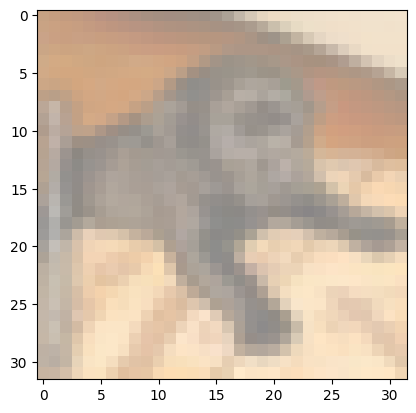

In [8]:
# Plot the input and sample
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(img.reshape(3, 32, 32))


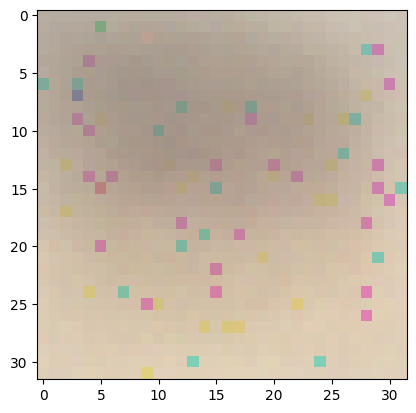

In [9]:
imshow(sample.reshape(1, 28, 28))

In [3]:
num_layers = 0
for name, param in model.score_net.named_parameters():
    num_layers += 1
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")
print(f"Total trainable layers: {num_layers}")


Layer: dense1.weight | Size: torch.Size([64, 64]) | Values : tensor([[ 0.0160,  0.0946, -0.1176,  0.1217,  0.0577, -0.0104, -0.0311,  0.0284,
         -0.0148,  0.1003, -0.0082, -0.0853,  0.0733,  0.0187, -0.0053, -0.0182,
         -0.0549,  0.0200,  0.0180,  0.0357, -0.0771,  0.0609,  0.0068,  0.0948,
          0.1058, -0.1080, -0.0979,  0.0785, -0.1196,  0.0313,  0.0683,  0.0657,
         -0.0343, -0.0015,  0.0382,  0.1038,  0.0082, -0.0015, -0.0167, -0.0462,
          0.1209,  0.0979,  0.0906,  0.0519,  0.0424,  0.0475, -0.0577,  0.1019,
          0.1156, -0.0348,  0.1173, -0.0167, -0.1213, -0.0411, -0.0379, -0.0885,
         -0.0773,  0.1178, -0.0044,  0.0307, -0.1166,  0.1165,  0.0636,  0.0549],
        [-0.0330,  0.1199,  0.0038,  0.0448, -0.0969, -0.0399, -0.0967,  0.0885,
          0.0022,  0.0655, -0.0509,  0.0693,  0.1014,  0.0973, -0.0718,  0.0542,
         -0.0473,  0.1001, -0.0661,  0.1199, -0.0006, -0.0099, -0.0112, -0.0690,
          0.0983, -0.0302, -0.0790,  0.0133,  0